In [1]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class NodeLookup(object):
    def __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
        
    def load(self, label_lookup_path, uid_lookup_path):
        # 加载分类字符转n*******对应各分类名称的文件，编号到实物
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human={}
        # 一行一行读取数据
        for line in proto_as_ascii_lines:
            line = line.strip('\n')
            parsed_items = line.split('\t')
            uid = parsed_items[0]
            human_string = parsed_items[1]
            uid_to_human[uid] = human_string
#         print(uid_to_human)
            
        # 加载分类字符串n*******对应分类编号1-1000的文件，softmax到编号
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
                    if line.strip().startswith('target_class:'):
                        target_class = int(line.strip().split(':')[1])
                    elif line.strip().startswith('target_class_'):
                        target_class_string = line.strip().split(':')[1].strip()
                        node_id_to_uid[target_class] = target_class_string[1:-1]
        #         print(node_id_to_uid)
        
        # 建立分类编号 1-1000 与对应分类名称的映射关系
        node_id_to_name = {}
        for key,val in node_id_to_uid.items():
            name = uid_to_human[val]
            node_id_to_name[key] = name
        
        return node_id_to_name
    
    # 传入分类编号1-1000 返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

images/微信图片_20190425134425.jpg


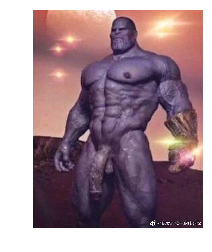

comic book (score = 0.32141)
cuirass (score = 0.09211)
breastplate, aegis, egis (score = 0.08145)
pedestal, plinth, footstall (score = 0.04785)
toyshop (score = 0.02314)
images/微信图片_20190425134444.jpg


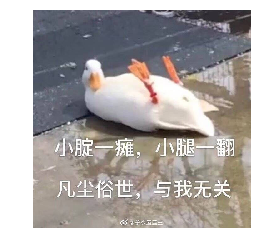

carton (score = 0.05929)
broom (score = 0.03033)
sleeping bag (score = 0.03028)
mosquito net (score = 0.02924)
monitor (score = 0.02512)
images/微信图片_20190425134450.jpg


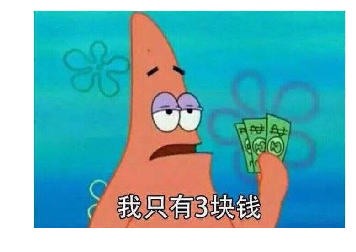

carton (score = 0.26177)
rubber eraser, rubber, pencil eraser (score = 0.07860)
comic book (score = 0.04821)
apron (score = 0.04211)
handkerchief, hankie, hanky, hankey (score = 0.04131)
images/微信图片_20190425134500.jpg


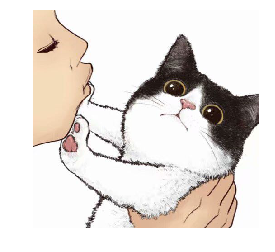

Egyptian cat (score = 0.09313)
Siamese cat, Siamese (score = 0.05604)
tabby, tabby cat (score = 0.03540)
carton (score = 0.03513)
bib (score = 0.02933)
images/微信图片_20190425134505.jpg


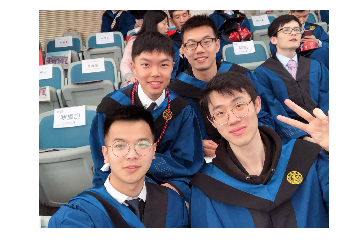

academic gown, academic robe, judge's robe (score = 0.22491)
mortarboard (score = 0.21691)
groom, bridegroom (score = 0.03590)
kimono (score = 0.02813)
military uniform (score = 0.02660)
images/微信图片_20190425135248.jpg


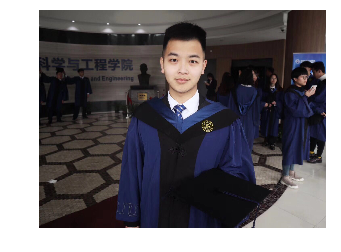

academic gown, academic robe, judge's robe (score = 0.63799)
mortarboard (score = 0.18369)
vestment (score = 0.01114)
kimono (score = 0.00797)
oboe, hautboy, hautbois (score = 0.00681)


In [4]:
# 创建一个图来存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb','rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

node_lookup = NodeLookup()

with tf.Session() as sess:
    # 拿到softmax的op
    # 'softmax:0'这个名字，可以在网络中找到这个节点，它的名字就'(softmax)',
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    for root,dirs,files in os.walk('images/'):
        for file in files:
            image_data = tf.gfile.FastGFile(os.path.join(root,file),'rb').read()
            # 运行softmax节点，向其中feed值
            # 可以在网络中找到这个名字，DecodeJpeg/contents，
            # 据此可以发现，根据名字取网络中op时，如果其名字带括号，就用括号内的名字，如果不带括号，就用右上角介绍的名字。
            # 而带个0，是默认情况，如果网络中出现同名节点，这个编号会递增
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0':image_data})
            predictions = np.squeeze(predictions)# 把结果转化为1维数据

            image_path = os.path.join(root, file)
            print(image_path)
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # 排序
            top_k = predictions.argsort()[-5:][::-1]
            for node_id in top_k:
                human_string = node_lookup.id_to_string(node_id)
                score = predictions[node_id]
                print('%s (score = %.5f)' % (human_string, score))